# Data Exploration

Protocol buffer parsing Inspired by
https://stackoverflow.com/questions/38958751/parsing-nyc-transit-mta-historical-gtfs-data-not-realtime

This extracts data from the protobufs manually downloaded from [MTA Alert Archive](http://web.mta.info/developers/data/archives.html)the latest source suggested at:
https://groups.google.com/d/msg/mtadeveloperresources/Whm5XTVINcE/z-LO12ANAAAJ

**NOTE:** You'll first need to download and extract data.  See [Data README](../docs/Data_README.md), [StatusExtractor.ipynb](StatusExtractor.ipynb) and [AlertScraper.ipynb] This expects data to have been downloaded under <code>data/raw/status</code> and <code>data/raw/alerts</code>

In [43]:
import os
import sys
data_dir = '../data/raw/status'
protobuf_dir = '../MTADelayPredict/protobuf'

In [44]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'gtfs-realtime.proto')
#! wget -O $proto_file https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto

In [45]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'nyct-subway.proto')
#! wget -O $proto_file https://api.mta.info/nyct-subway.proto.txt

In [46]:
#! protoc -I $protobuf_dir --python_out=$protobuf_dir $protobuf_dir/nyct-subway.proto $protobuf_dir/gtfs-realtime.proto

## Examine Alerts

First, fetch the alert from the downloaded alert data.

### Load alert historical data

In [47]:
import pandas as pd
import numpy as np
import os 

In [48]:
alert_dir = '../data/raw/alerts'
alert_df = pd.read_csv(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_12.01.2018_12.31.2018.csv')))
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [7]:
alert_df.head(10)

,Agency,Subject,Message
Date,,,
2018-12-01 00:25:00,NYC,"UPDATED: MANH, A Trains, NYPD Activity",Northbound A train service has resumed after e...
2018-12-01 00:34:00,NYC,"BKLYN, 2 and 4 Trains, Rail Replacement.",Northbound 2 and 4 trains are running express ...
2018-12-01 00:55:00,NYC,"MANH, 1 Trains, Vandalism.",Northbound 1 trains are delayed while we remov...
2018-12-01 00:57:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 train service has resumed after w...
2018-12-01 00:58:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 trains are no longer delayed afte...
2018-12-01 01:35:00,NYC,"BX, 4 Trains, Track Maintenance.",Southbound 4 trains are bypassing 138 St-Grand...
2018-12-01 01:45:00,NYC,"MANH, 2 Trains, Track Maintenance.",Southbound 2 trains are running express from 9...
2018-12-01 02:21:00,NYC,"MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q trains are holding in stati...
2018-12-01 02:27:00,NYC,"UPDATED: MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q train service has resumed a...


### Load subway gtfs statuses from this time period

Also download stop ID's to make this more easily explorable

In [49]:
#!wget -O $data_dir/Stations.csv http://web.mta.info/developers/data/nyct/subway/Stations.csv 
stations_df = pd.read_csv(data_dir + '/Stations.csv')
stations_df.index = stations_df['GTFS Stop ID']

In [50]:
# We are looking for station R16 aka Times Sq - 42 St
stations_df.loc['R16']

Station ID                                11
Complex ID                               611
GTFS Stop ID                             R16
Division                                 BMT
Line                     Broadway - Brighton
Stop Name                   Times Sq - 42 St
Borough                                    M
Daytime Routes                       N Q R W
Structure                             Subway
GTFS Latitude                        40.7547
GTFS Longitude                      -73.9868
North Direction Label        Uptown & Queens
South Direction Label    Downtown & Brooklyn
Name: R16, dtype: object

In [51]:
# Download some other stuff we need for processing data
#!wget -O $data_dir/google_transit.zip http://web.mta.info/developers/data/nyct/subway/google_transit.zip
#import zipfile
#with zipfile.ZipFile(data_dir+'/google_transit.zip') as zf:
#    zf.extractall(data_dir+'/google_transit')

In [52]:
stop_ids = pd.read_csv(data_dir+'/google_transit/stops.txt')

In [53]:
STOP_FILTER = '^R60N$'
stop_ids[stop_ids['stop_id'].str.match(STOP_FILTER)].stop_id

Series([], Name: stop_id, dtype: object)

In [54]:
! ls $data_dir/google_transit

agency.txt    calendar_dates.txt  shapes.txt	  stops.txt	 trips.txt
calendar.txt  routes.txt	  stop_times.txt  transfers.txt


## Parse Protobufs
Have a look at what is actually in these messages.

A great writeup of the mta gtfs feed contents can be found here: https://www.residentmar.io/2018/01/29/gtfs-tripify.html

In [55]:
import sys
sys.path.append(os.path.join(data_dir))
import nyct_subway_pb2
import gtfs_realtime_pb2

In [56]:
msg = gtfs_realtime_pb2.FeedMessage()

with open(os.path.join(data_dir, '201812/20181209/gtfs_nqrw_20181209_042657.gtfs'),'rb') as fh:
    msg.ParseFromString(fh.read())

In [57]:
print(msg)

header {
  gtfs_realtime_version: "1.0"
  incrementality: FULL_DATASET
  timestamp: 1544347617
  [nyct_feed_header] {
    nyct_subway_version: "1.0"
    trip_replacement_period {
      route_id: "N"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "W"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "Q"
      replacement_period {
        end: 1544349408
      }
    }
    trip_replacement_period {
      route_id: "R"
      replacement_period {
        end: 1544349404
      }
    }
  }
}
entity {
  id: "16000001"
  trip_update {
    trip {
      trip_id: "020158_N..S"
      start_date: "20181209"
      route_id: "N"
      [nyct_trip_descriptor] {
        train_id: "1N 0318+ QBP/STL"
        is_assigned: true
        direction: SOUTH
      }
    }
    stop_time_update {
      arrival {
        time: 1544347607
      }
      departure {
        time: 1544347607
      

## Calculate Wait Times

This requires [StatusExtractor.ipynb](StatusExctractor.ipynb) to have been run and dumped h5 data to disk.

In [2]:
# relative MTADelayPredict Project
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.utils import gtfs_loader

from importlib import reload
reload(gtfs_loader)
reload(stops)

NameError: name 'stops' is not defined

In [59]:
foo = stops.stopid2name('R15N')

In [60]:
foo

'49 St'

In [61]:
import glob
import pandas as pd

#status_files = glob.glob(os.path.join(data_dir, 'status_*.h5'))
status_files = glob.glob(os.path.join(data_dir, 'status_201808.h5'))
#status_files = glob.glob(os.path.join(data_dir, 'status_northbound_n_*.h5'))
stopped_at = []
next_train = []
next_scheduled_arrival = []

for f in status_files:
    stopped_at.append(pd.read_hdf(f, key='stopped_at'))
    next_train.append(pd.read_hdf(f, key='next_train'))
    next_scheduled_arrival.append(pd.read_hdf(f, key='next_scheduled_arrival'))
stopped_at_df = pd.concat(stopped_at)
next_train_df = pd.concat(next_train)
next_scheduled_arrival_df = pd.concat(next_scheduled_arrival)

In [62]:
stopped_at_df['R16N']

2018-08-01 04:20:27-04:00    1N 0317 STL/DIT
2018-08-01 04:20:42-04:00    1N 0317 STL/DIT
2018-08-01 04:21:02-04:00    1N 0317 STL/DIT
2018-08-01 04:21:17-04:00    1N 0317 STL/DIT
2018-08-01 04:21:27-04:00    1N 0317 STL/DIT
                                  ...       
2018-08-31 23:39:38-04:00    1N 2231 STL/DIT
2018-08-31 23:40:03-04:00    1N 2231 STL/DIT
2018-08-31 23:40:28-04:00    1N 2231 STL/DIT
2018-08-31 23:50:28-04:00    1N 2243 STL/DIT
2018-08-31 23:51:03-04:00    1N 2243 STL/DIT
Name: R16N, Length: 14613, dtype: object

In [63]:
stopped_at_df.replace(0.0, np.nan).dropna(how='all')

,R16N
2018-08-01 04:20:27-04:00,1N 0317 STL/DIT
2018-08-01 04:20:42-04:00,1N 0317 STL/DIT
2018-08-01 04:21:02-04:00,1N 0317 STL/DIT
2018-08-01 04:21:17-04:00,1N 0317 STL/DIT
2018-08-01 04:21:27-04:00,1N 0317 STL/DIT
...,...
2018-08-31 23:39:38-04:00,1N 2231 STL/DIT
2018-08-31 23:40:03-04:00,1N 2231 STL/DIT
2018-08-31 23:40:28-04:00,1N 2231 STL/DIT
2018-08-31 23:50:28-04:00,1N 2243 STL/DIT


In [64]:
stopped_at_df

,R16N
2018-08-01 04:20:27-04:00,1N 0317 STL/DIT
2018-08-01 04:20:42-04:00,1N 0317 STL/DIT
2018-08-01 04:21:02-04:00,1N 0317 STL/DIT
2018-08-01 04:21:17-04:00,1N 0317 STL/DIT
2018-08-01 04:21:27-04:00,1N 0317 STL/DIT
...,...
2018-08-31 23:39:38-04:00,1N 2231 STL/DIT
2018-08-31 23:40:03-04:00,1N 2231 STL/DIT
2018-08-31 23:40:28-04:00,1N 2231 STL/DIT
2018-08-31 23:50:28-04:00,1N 2243 STL/DIT


### How Frequently do we get updates, and what time of day?

In [65]:
stopped_at_df = stopped_at_df.sort_index()
next_train_df = next_train_df.sort_index()
next_scheduled_arrival_df = next_scheduled_arrival_df.sort_index()

In [66]:
# Gap between times
stopped_at_df['time'] = stopped_at_df.index
time_till_next_obs = pd.DataFrame(columns=['time'])
# There is generally a gap between end of day and start of day, or if there are missing day
# we need to calculate time until next train within each day and not accidentally count overnight
deltas = []

for _,d in stopped_at_df.groupby(stopped_at_df.index.date):
    deltas.append((d.time.shift(-1) - d.time).to_frame())
#for _,d in new_stops.groupby(new_stops.index.date):
#    time_till_next_obs.loc[d.index, 'time'] = d.time.shift(-1) - d.time

time_till_next_obs = pd.concat(deltas)
time_till_next_obs = time_till_next_obs.dropna(how='all')
time_till_next_obs = time_till_next_obs.between_time('04:00','19:00')
#time_till_next_obs = (new_stops.time.shift(-1) - new_stops.time).to_frame()
time_till_next_obs['minutes'] = time_till_next_obs['time'].map(lambda x: x.total_seconds() / 60. )
time_till_next_obs['TOD'] = time_till_next_obs.index.map(lambda x: x.hour)

In [67]:
import seaborn as sns

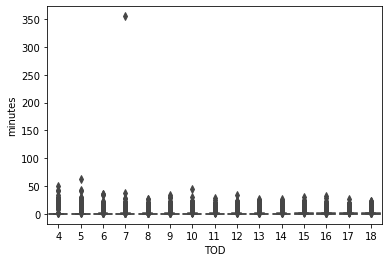

In [68]:
sns.boxplot(x="TOD", y="minutes",
            data=time_till_next_obs)

(0.0, 5.0)

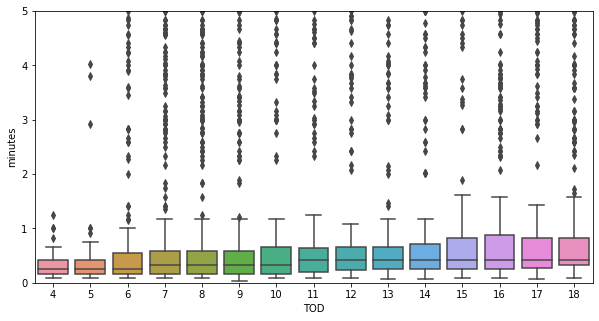

In [69]:
# It looks like there are quite a few outliers with messaging over 1 minute, but overall, updates are sub 1 minute.
# TODO: Determine if these gaps are due to failed parsing, or just updates that don't happen regularly
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

ax = sns.boxplot(x="TOD", y="minutes", data=time_till_next_obs)
ax.set_ylim([0, 5])

### Calculate time between train departure, and the next train
Only do this between 04:00 and 19:00, as trains run sporadically outside of that date range

In [70]:
new_stops = stopped_at_df[stopped_at_df != stopped_at_df.shift(1)].dropna()
new_stops['time'] = new_stops.index
new_stops.fillna(method='ffill', inplace=True)

time_till_next_obs = pd.DataFrame(columns=['time'])
# There is generally a gap between end of day and start of day, or if there are missing day
# we need to calculate time until next train within each day and not accidentally count overnight
deltas = []
new_stops = new_stops.sort_index()

for _,d in new_stops.groupby(new_stops.index.date):
    deltas.append((d.time.shift(-1) - d.time).to_frame())
#for _,d in new_stops.groupby(new_stops.index.date):
#    time_till_next_obs.loc[d.index, 'time'] = d.time.shift(-1) - d.time

time_till_next_obs = pd.concat(deltas)
time_till_next_obs = time_till_next_obs.dropna(how='all')
time_till_next_obs = time_till_next_obs.between_time('04:00','21:00')
#time_till_next_obs = (new_stops.time.shift(-1) - new_stops.time).to_frame()
time_till_next_obs['minutes'] = time_till_next_obs['time'].map(lambda x: x.total_seconds() / 60. )
time_till_next_obs['TOD'] = time_till_next_obs.index.map(lambda x: x.hour)

(0.0, 60.0)

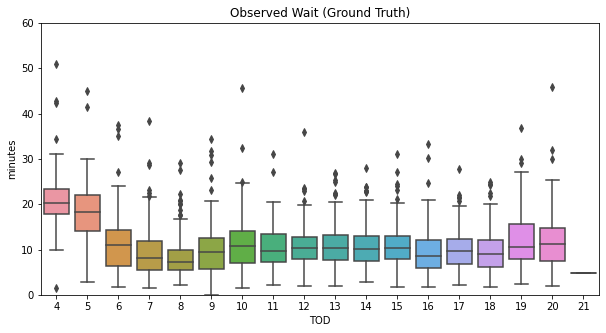

In [71]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="TOD", y="minutes", data=time_till_next_obs)
ax.set_title("Observed Wait (Ground Truth)")
ax.set_ylim([0, 60])

In [72]:
time_till_next_obs['GroundTruth'] = time_till_next_obs['minutes']
scheduled_time = pd.Series(time_till_next_obs.index.map(lambda x: next_scheduled_arrival_df.iloc[next_scheduled_arrival_df.index.searchsorted(x, side='right', sorter=None), 0].tz_convert('US/Eastern')))
scheduled_time.index = time_till_next_obs.index


In [73]:
scheduled_time

2018-08-01 04:20:27-04:00   2018-08-01 04:42:32-04:00
2018-08-01 04:42:42-04:00   2018-08-01 05:02:42-04:00
2018-08-01 05:03:27-04:00   2018-08-01 05:25:37-04:00
2018-08-01 05:26:02-04:00   2018-08-01 05:43:52-04:00
2018-08-01 05:43:42-04:00   2018-08-01 05:56:57-04:00
                                       ...           
2018-08-31 20:06:52-04:00   2018-08-31 20:19:07-04:00
2018-08-31 20:20:07-04:00   2018-08-31 20:35:45-04:00
2018-08-31 20:31:42-04:00   2018-08-31 20:35:45-04:00
2018-08-31 20:36:30-04:00   2018-08-31 20:53:07-04:00
2018-08-31 20:54:02-04:00   2018-08-31 21:12:53-04:00
Length: 2810, dtype: datetime64[ns, US/Eastern]

In [74]:
time_till_next_obs['MTAPredict'] = (scheduled_time - time_till_next_obs.index).map(lambda x: x.total_seconds() / 60.0)

In [75]:
wait_time = time_till_next_obs.loc[:, ['GroundTruth', 'MTAPredict', 'TOD']]

### Examine train status against alert data

In [76]:
# Find if alerts are predictive
# Get a list of alert times for N train
import numpy as np
alert_dir = '../data/raw/alerts'
alert_files = glob.glob(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_*.csv')))
alert_list = []
for f in alert_files:
    alert_list.append(pd.read_csv(f))
alert_df = pd.concat(alert_list)
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [77]:
# Train wait time
train_wait = time_till_next_obs.replace(0, np.nan).dropna()

In [78]:
print(alert_df['2018-8'])

                    Agency                                            Subject  \
Date                                                                            
2018-08-01 00:18:00    NYC  UPDATED: BKLYN, J Trains, Person Struck by a T...   
2018-08-01 01:04:00    NYC                     QNS, 7 Trains, Switch Problems   
2018-08-01 01:16:00    NYC  UPDATED: BKLYN, J Trains, Person Struck by a T...   
2018-08-01 01:20:00    NYC            UPDATED: QNS, 7 Trains, Switch Problems   
2018-08-01 01:24:00    NYC  MANH, 1 and 2 Trains, Temporary Track Maintenance   
...                    ...                                                ...   
2018-08-31 21:26:00    NYC            UPDATED: BX, D Trains, Brakes Activated   
2018-08-31 21:27:00    NYC            UPDATED: BX, D Trains, Brakes Activated   
2018-08-31 23:05:00    NYC                BKLYN, F Trains, Medical Assistance   
2018-08-31 23:09:00    NYC  BX, 2 and 5 Trains, Unauthorized person on the...   
2018-08-31 23:36:00    NYC  

In [79]:
train_alerts = alert_df.loc[alert_df.Subject.str.match(r'.* N(?:(, )|( and)).*')]
train_alerts = train_alerts.sort_index()

In [80]:
train_alerts.loc['2018-08-01':'2019-06-30'].between_time('5:00','21:00').to_csv(alert_dir+'/nqrw_alerts.csv')

In [81]:
# Add some predictors for the train_alerts
import re
subject_regex = r'^(?P<updated>UPDATED)?:? ?(?P<borough>[A-Z]+), (?P<trains>.*) Trains?, (?P<alert_type>.*)$'
message_regex = r'^(P<direction>Northbound|Southbound|Westbound|Eastbound)?.*$'


re.match(subject_regex, train_alerts.iloc[0].Subject).group('alert_type')
re.match(message_regex, train_alerts.iloc[0].Message).groups()

('Southbound',)

In [82]:
train_alerts.Message[25]

'N and R train service has resumed following an earlier incident involving a train with mechanical problems at 36 St (Bklyn).'

In [83]:
alert_features = train_alerts.Subject.str.extract(subject_regex)
alert_features['updated'] = alert_features['updated'] == 'UPDATED'

for train in ['N', 'Q', 'R', 'W']:
    alert_features[train] = alert_features['trains'].str.contains(train)
    
alert_features['direction'] = train_alerts.Message.str.extract(message_regex)[0]
alert_features['delays'] = train_alerts.Message.str.match('.*delay.*')
alert_features.drop(columns='trains')

,updated,borough,alert_type,N,Q,R,W,direction,delays
Date,,,,,,,,,
2018-01-01 00:20:00,True,MANH,Signal Problems,True,False,True,False,Southbound,True
2018-01-01 02:50:00,False,MANH,Signal Problems,True,True,False,False,Southbound,False
2018-01-01 03:12:00,True,MANH,Signal Problems,True,True,False,False,NaN,False
2018-01-01 12:24:00,False,MANH,Signal Problems,True,False,True,False,Southbound,True
2018-01-01 14:02:00,True,MANH,Signal Problems,True,False,True,False,Southbound,True
...,...,...,...,...,...,...,...,...,...
2019-06-28 10:05:00,True,MANH,Brakes Activated,True,True,False,False,Southbound,True
2019-06-28 10:05:00,True,MANH,Brakes Activated,True,True,False,False,Southbound,True
2019-06-28 18:12:00,True,MANH,Door Problem,True,False,True,True,Southbound,True


In [84]:
alert_features[ (alert_features.N == True) & alert_features.alert_type.str.contains('Brake')  ]

,updated,borough,trains,alert_type,N,Q,R,W,direction,delays
Date,,,,,,,,,,
2018-06-23 07:12:00,False,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,Southbound,True
2018-06-23 07:22:00,True,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,NaN,False
2018-07-04 18:02:00,False,MANH,N and R,Emergency Brakes Activated,True,False,True,False,NaN,False
2018-07-04 18:49:00,True,MANH,N and R,Emergency Brakes Activated,True,False,True,False,NaN,False
2018-07-09 17:22:00,False,MANH,"N, Q, R and W",Brakes Activated,True,True,True,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...
2019-06-27 13:08:00,True,BKLYN,"D, N and R",Brakes Activated,True,False,True,False,Southbound,True
2019-06-28 09:32:00,False,BKLYN,N and R,Brakes Activated,True,False,True,False,Southbound,False
2019-06-28 09:42:00,False,MANH,N and Q,Brakes Activated,True,True,False,False,Southbound,True


In [85]:
train_alerts = alert_df.loc[alert_df.Subject.str.match(r'.* N(?:(, )|( and)).*') & alert_df.Message.str.match(r'.*delay.*')]
train_alerts = train_alerts.sort_index()

for i,ts in enumerate(train_alerts.index[:-1]):
    ts1 = pd.Timestamp(ts, tz='US/Eastern')
    ts2 = pd.Timestamp(train_alerts.index[i+1], tz='US/Eastern')
    wait_time.loc[ts1:ts2, 'LastAlertTime'] = ts1
wait_time.loc[ts2:, 'LastAlertTime'] = ts1

In [86]:
for x,y in zip(wait_time.index, wait_time['LastAlertTime']):
    wait_time.loc[x, 'MinSinceAlert'] = (x-y).total_seconds() / 60.0

In [87]:
alert_mask = wait_time.MinSinceAlert < 30

In [88]:
train_wait['Alerted'] = alert_mask

In [89]:
# g = sns.FacetGrid(train_wait, col="Alerted", row="TOD", height=1.7, aspect=2, xlim=(0, 30), ylim=(0,.2))
# g.map(sns.distplot, "GroundTruth", color='b', label='GroundTruth')
# g.map(sns.distplot, "MTAPredict", color='r', label='MTAPredict')
# g.add_legend();


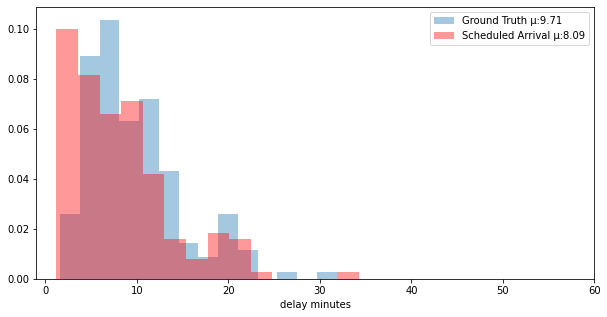

In [90]:
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
plt.figure(figsize=(10,5))
ax = sns.distplot(wait_time['GroundTruth'].loc[alert_time_mask], kde=False, norm_hist=True, label='Ground Truth \u03BC:{:.2f}'.format(wait_time['GroundTruth'].loc[alert_time_mask].mean()))
sns.distplot(wait_time['MTAPredict'].loc[alert_time_mask], ax=ax, color='r', kde=False, norm_hist=True, label='Scheduled Arrival \u03BC:{:.2f}'.format(wait_time['MTAPredict'].loc[alert_time_mask].mean()))
ax.set_xlim([-1, 60])
ax.set_xlabel('delay minutes')
ax.legend()

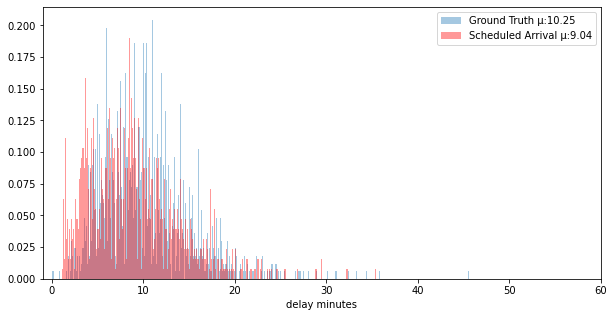

In [91]:
alert_time_mask = (wait_time.MinSinceAlert > 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
plt.figure(figsize=(10,5))
ax = sns.distplot(wait_time['GroundTruth'].loc[alert_time_mask], kde=False, bins=500, norm_hist=True, label='Ground Truth \u03BC:{:.2f}'.format(wait_time['GroundTruth'].loc[alert_time_mask].mean()))
sns.distplot(wait_time['MTAPredict'].loc[alert_time_mask], ax=ax, color='r', kde=False, bins=500, norm_hist=True, label='Scheduled Arrival \u03BC:{:.2f}'.format(wait_time['MTAPredict'].loc[alert_time_mask].mean()))
ax.set_xlim([-1, 60])
ax.set_xlabel('delay minutes')
ax.legend()

In [92]:
from sklearn.metrics import mean_squared_error

In [93]:
alert_time_mask = (wait_time.MinSinceAlert >=  5) & (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
mean_squared_error(y_true=wait_time['GroundTruth'].loc[alert_time_mask], y_pred=wait_time['MTAPredict'].loc[alert_time_mask], squared=False)

2.79700360505071

In [94]:
alert_time_mask = (wait_time.MinSinceAlert >= 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
mean_squared_error(y_true=wait_time['GroundTruth'].loc[alert_time_mask], y_pred=wait_time['MTAPredict'].loc[alert_time_mask], squared=False)

2.0803490028079805

In [95]:
from scipy.stats import ttest_ind
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
ttest_ind(wait_time['GroundTruth'].loc[alert_time_mask].dropna(), wait_time['GroundTruth'].loc[~alert_time_mask].dropna())


Ttest_indResult(statistic=-2.009744881007865, pvalue=0.04455369155778095)

In [96]:
from scipy.stats import ks_2samp
alert_time_mask = (wait_time.MinSinceAlert < 60) & (wait_time.TOD < 19) & (wait_time.TOD > 7)
ks_2samp(wait_time['GroundTruth'].loc[alert_time_mask].dropna(), wait_time['GroundTruth'].loc[~alert_time_mask].dropna(), alternative='greater')

Ks_2sampResult(statistic=0.1370656687511284, pvalue=0.002986065164851988)

In [97]:
wait_time['Time'] = wait_time.index

In [98]:
wait_time['RSE'] = (wait_time['GroundTruth'] - wait_time['MTAPredict']).pow(2).pow(.5)

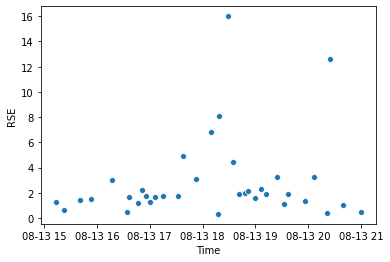

In [99]:
#Examine the mta scheduled arrival time error around a particularly bad alert period on 2018-08-13 21:00-4:00
sns.scatterplot(x='Time', y='RSE', data=wait_time.loc['2018-08-13 15:00-4:00':'2018-08-13 21:00-4:00'])

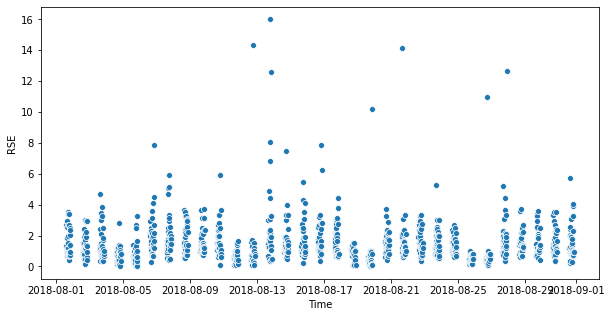

In [100]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='Time', y='RSE', data=wait_time.loc['2018-08-01 06:00-4:00':'2018-08-31 21:00-4:00'].between_time('15:00', '21:00'))

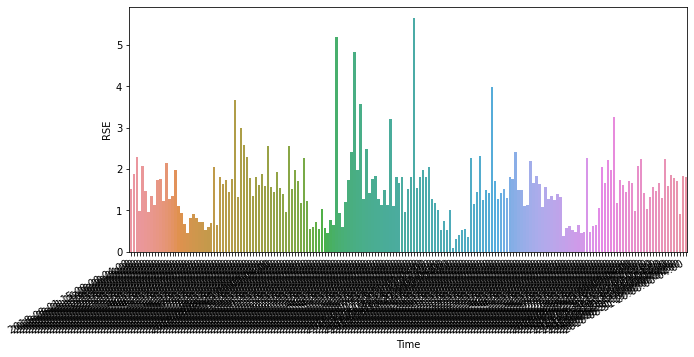

In [101]:
plt.figure(figsize=(10,5))
fig = plt.gcf()
df = wait_time.loc['2018-08-01 06:00-4:00':'2018-08-31 21:00-4:00', 'RSE'].between_time('15:00', '21:00').resample('1H').mean().to_frame().dropna()
df['Time'] = df.index
ax = sns.barplot(x='Time', y='RSE', data=df)
fig.autofmt_xdate()

In [102]:
#wait_time.loc['2019-06-02 03:00':'2019-06-02 10:00'].GroundTruth.resample('15T').mean().plot()

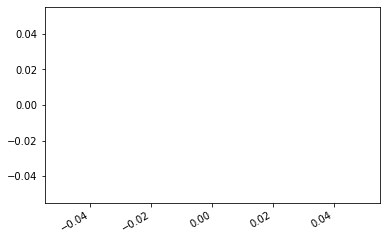

In [103]:
wait_time.loc['2019-06-01 03:00':'2019-06-01 10:00'].GroundTruth.plot()

In [1]:
# relative MTADelayPredict Project
import sys
import os
import pandas as pd

sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.utils import gtfs_loader
from importlib import reload
reload(gtfs_loader)

<module 'MTADelayPredict.utils.gtfs_loader' from '/opt/project/MTADelayPredict/utils/gtfs_loader.py'>

In [2]:
from MTADelayPredict.plotting import alerts

25561311
25561431


100%|#####################################|entries: ------decode_errors: ------


New stops:
set()


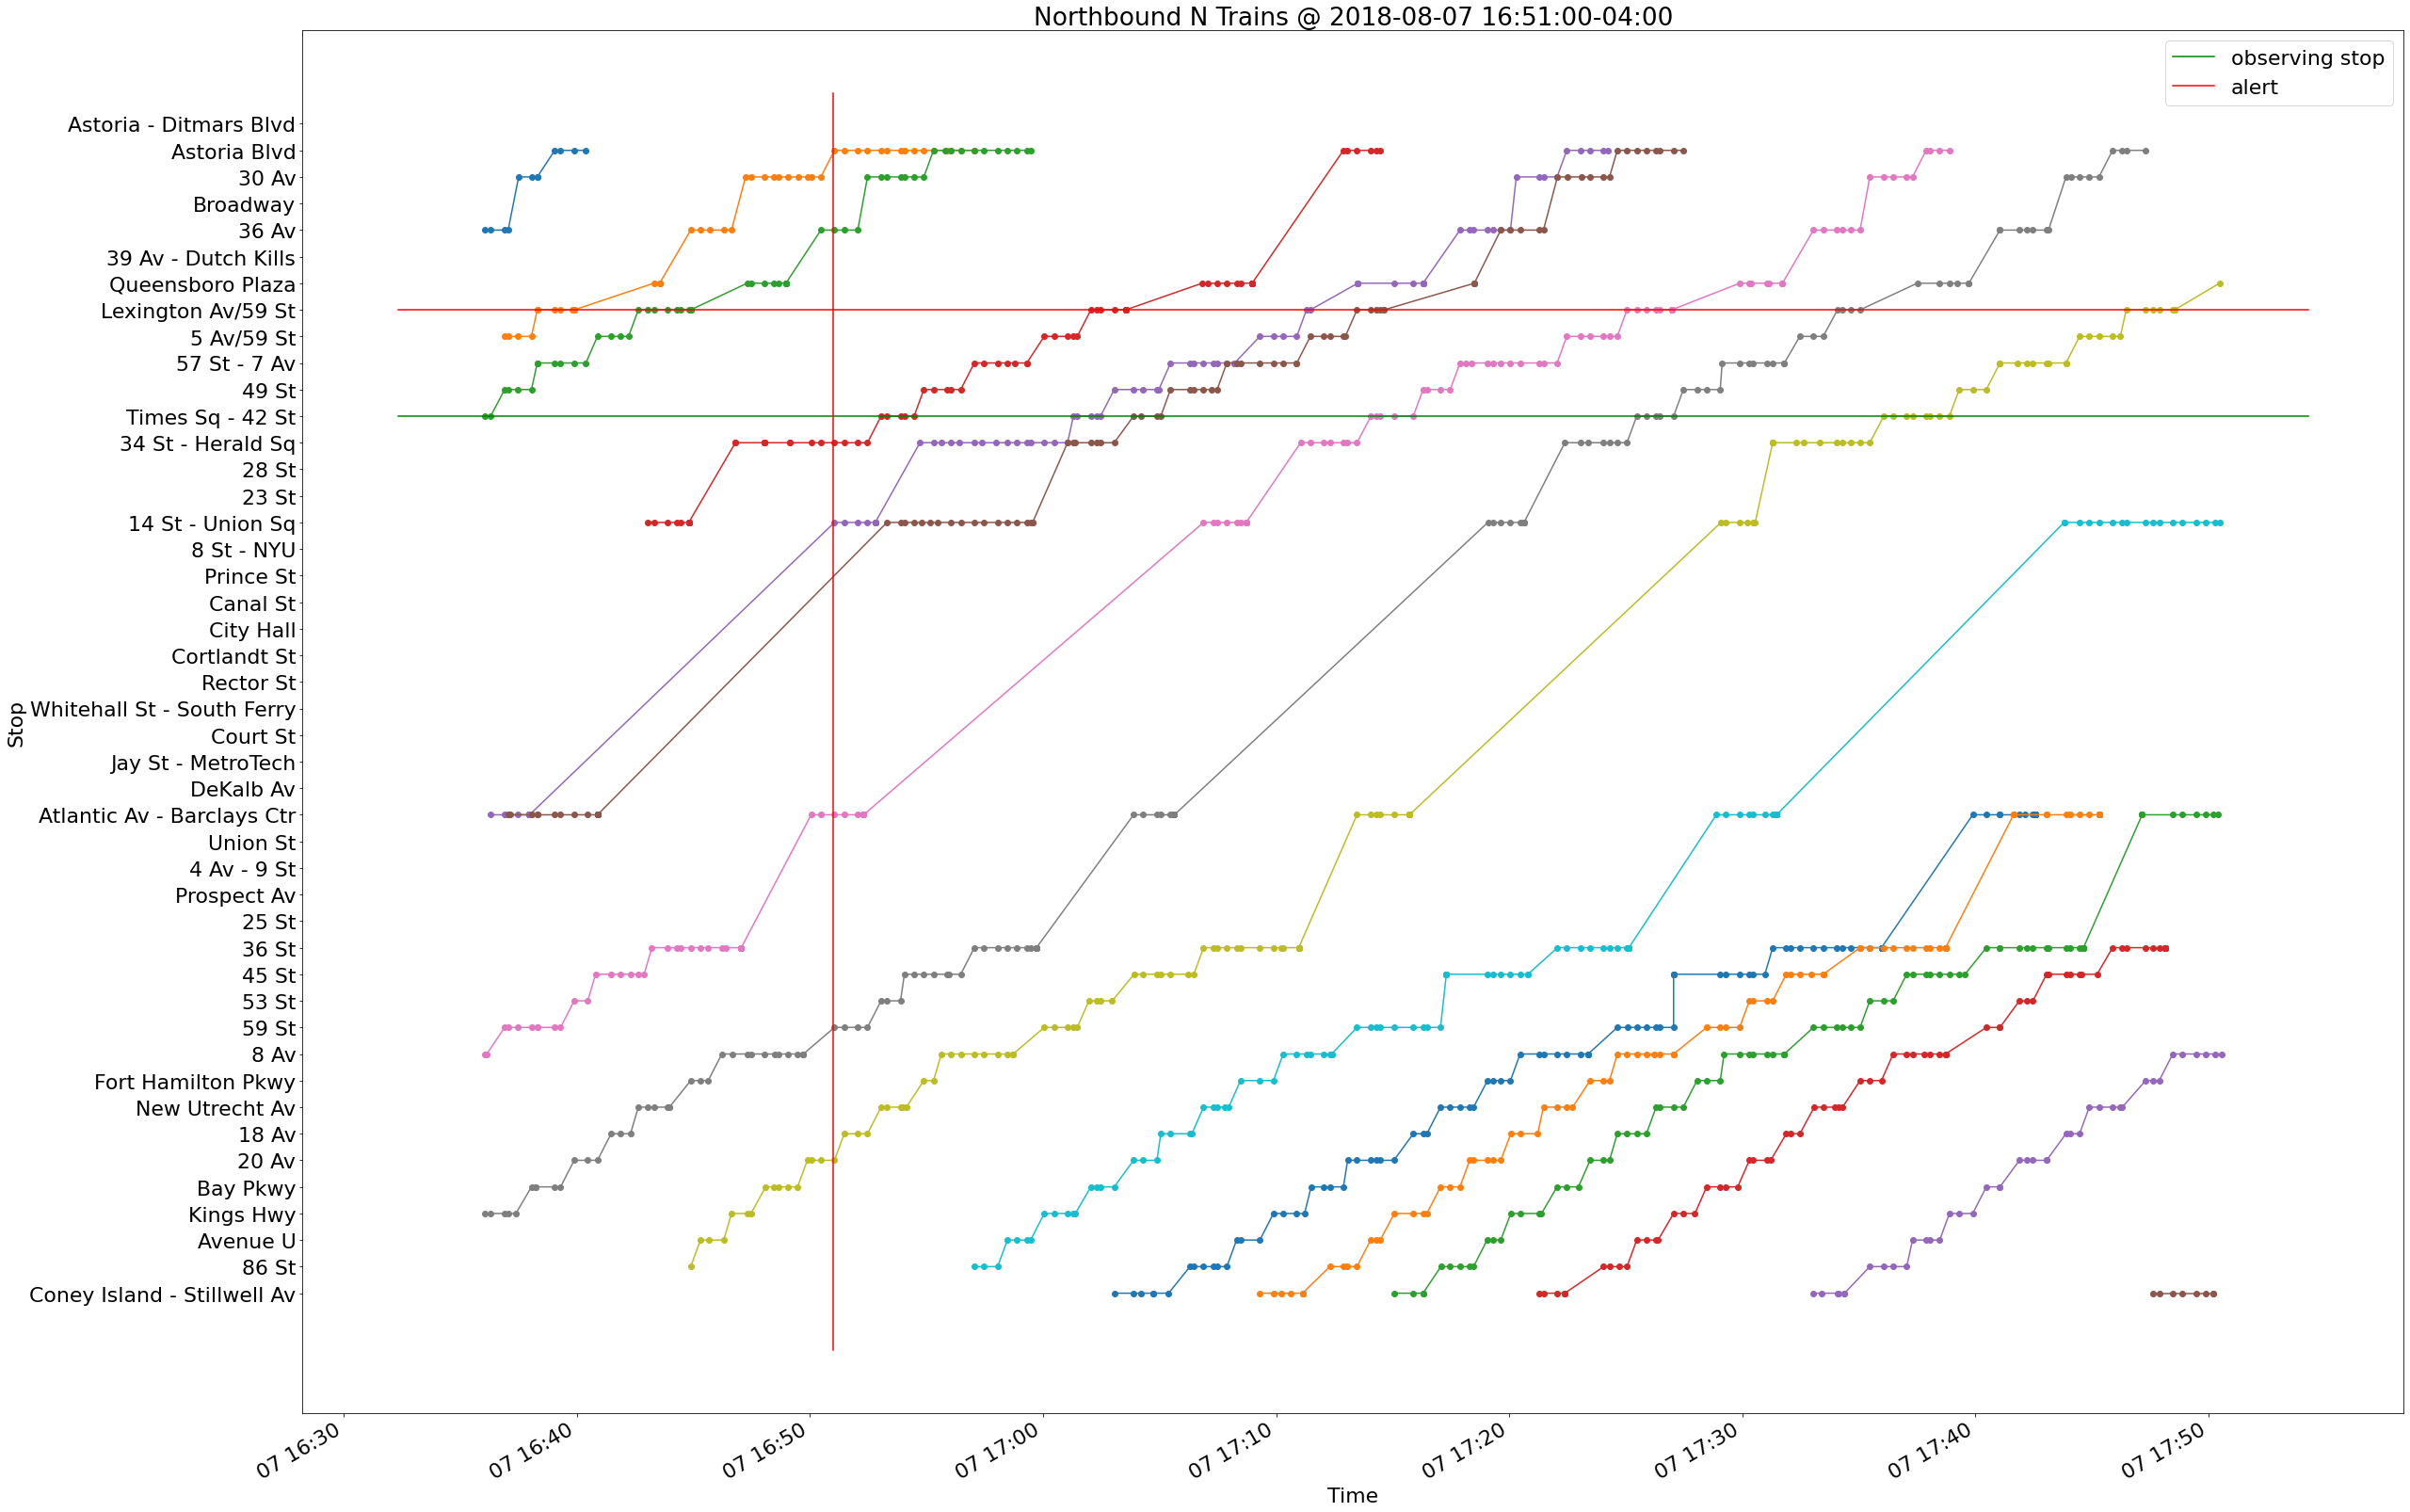

In [4]:
alert_time = pd.Timestamp('2018-08-07 16:51:00', tz='US/Eastern')
STOP_FILTER = '^.*N$'
ROUTE_FILTER = 'N'
fig = alerts.plot_alert(alert_time, observing_stop='R16N', alert_stop='R11N', stop_filter=STOP_FILTER, route_filter=ROUTE_FILTER)

In [13]:
import matplotlib.pyplot as plt
plt.figure(fig.number)
fig.savefig('/opt/project/foo.png')

<Figure size 432x288 with 0 Axes>

In [225]:
STOP_FILTER = '^.*N$'
#ROUTE_FILTER = '[N|Q|R|W]'
ROUTE_FILTER = 'N'
start_date = pd.Timestamp('2018-08-07  00:00')
end_date = pd.Timestamp('2018-08-07 23:59')
loader = gtfs_loader.GTFSLoader(data_dir=os.path.join('../data/raw/status'), \
                                train_line='nqrw')
loader.load_range(start_date, end_date, stop_filter=STOP_FILTER, route_filter=ROUTE_FILTER, verbose=True, schedule=True)

25561439
25561559


100%|#####################################|entries: ------decode_errors:     38


New stops:
set()


{'stopped_at':                            D43N  N10N  N09N     N08N     N07N     N06N  N05N  \
 2018-08-06 20:00:00-04:00   0.0   0.0   0.0      0.0      0.0      0.0   0.0   
 2018-08-06 20:01:00-04:00   0.0   0.0   0.0      0.0      0.0      0.0   0.0   
 2018-08-06 20:02:00-04:00   0.0   0.0   0.0      0.0      0.0      0.0   0.0   
 2018-08-06 20:03:00-04:00   0.0   0.0   0.0      0.0      0.0      0.0   0.0   
 2018-08-06 20:04:00-04:00   0.0   0.0   0.0      0.0      0.0      0.0   0.0   
 ...                         ...   ...   ...      ...      ...      ...   ...   
 2018-08-07 21:54:00-04:00   0.0   0.0   0.0  12148.0      0.0      0.0   0.0   
 2018-08-07 21:55:00-04:00   0.0   0.0   0.0  12148.0      0.0      0.0   0.0   
 2018-08-07 21:56:00-04:00   0.0   0.0   0.0      0.0  12148.0      0.0   0.0   
 2018-08-07 21:57:00-04:00   0.0   0.0   0.0      0.0      0.0  12148.0   0.0   
 2018-08-07 21:58:00-04:00   0.0   0.0   0.0      0.0      0.0  12148.0   0.0   
 
            

In [383]:
print(schedule_df.stop_id.tolist())

['B08N', 'B12N', 'B13N', 'B14N', 'B15N', 'B16N', 'B17N', 'B18N', 'B19N', 'B20N', 'B21N', 'B22N', 'B23N', 'D43N', 'N02N', 'N03N', 'N04N', 'N05N', 'N06N', 'N07N', 'N08N', 'N09N', 'N10N', 'Q01N', 'Q03N', 'Q04N', 'Q05N', 'R01N', 'R03N', 'R04N', 'R05N', 'R06N', 'R08N', 'R09N', 'R11N', 'R13N', 'R14N', 'R15N', 'R16N', 'R17N', 'R18N', 'R19N', 'R20N', 'R21N', 'R22N', 'R23N', 'R24N', 'R25N', 'R26N', 'R27N', 'R28N', 'R29N', 'R30N', 'R31N', 'R32N', 'R33N', 'R34N', 'R35N', 'R36N', 'R39N', 'R40N', 'R41N']


In [382]:
print(schedule_df.stop_idx.tolist())

[700, 706, 709, 712, 715, 718, 721, 724, 727, 730, 733, 736, 739, 859, 1267, 1270, 1273, 1276, 1279, 1282, 1285, 1288, 1291, 1297, 1300, 1303, 1306, 1309, 1312, 1315, 1318, 1321, 1324, 1327, 1330, 1333, 1336, 1339, 1342, 1345, 1348, 1351, 1354, 1357, 1360, 1363, 1366, 1369, 1372, 1375, 1378, 1381, 1384, 1387, 1390, 1393, 1396, 1399, 1402, 1405, 1408, 1411]


In [373]:
schedule_df['StationName'] = schedule_df.index

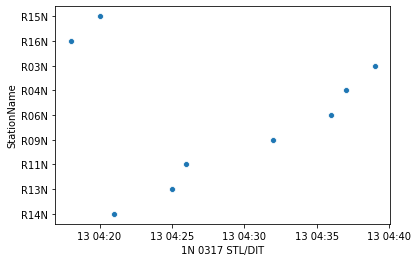

In [374]:
sns.scatterplot(x='1N 0317 STL/DIT', y='StationName', data=schedule_df)